In [1]:
suppressPackageStartupMessages({
    library(limma)
    library(imputeLCMD)
    library(ggplot2)
    library(ggsci)
    library(rrcovNA)


})


impute.perseus <- function(x, width=0.3, shift=1.8) {
  # distributions are induced by measured values in each sample
  data.mean <- colMeans(x, na.rm = TRUE)
  data.sd <- matrixStats::colSds(x, na.rm = TRUE)
  n <- nrow(x)
  z <- rmvnorm(n, mean = data.mean - shift*data.sd , sigma = diag(data.sd*width))
  x[is.na(x)] <- z[is.na(x)]
  return(x)
}



fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}


devtools::load_all("/stornext/General/data/academic/lab_davis/prot/benchmarking/msImpute/")

ℹ Loading msImpute



In [2]:
dda <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD015300/evidence.tsv",
                  stringsAsFactors = FALSE)



keep1 <- (!grepl("CON__|REV__", dda$Leading.razor.protein))
keep2 <- (dda$Modifications %in% "Unmodified")



dda <- dda[keep1&keep2,]
dda <- dda[dda$Charge > 1,]
dda$PeptideID <- paste0(dda$Modified.sequence, dda$Charge)
dda$matrix.row.id <- paste(dda$PeptideID, dda$Leading.razor.protein, sep ="_")


genes <- dda[,c("PeptideID","matrix.row.id", "Leading.razor.protein")]
genes <- genes[!duplicated(genes),]


y_dda <- evidenceToMatrix(dda)

keep3 <- rowSums(!is.na(y_dda)) >= 4
table(keep3)



y_dda <- y_dda[keep3,]

#ensure column names are allowed names
colnames(y_dda) <- gsub("-","_", colnames(y_dda))
genes <- genes[match(rownames(y_dda), genes$PeptideID),]
rownames(y_dda) <- genes$matrix.row.id




y_dda <- log2(y_dda)
# y_dda <- normalizeBetweenArrays(y_dda, method = "quantile")
colnames(y_dda) <- gsub("-","_", colnames(y_dda))

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

keep3
FALSE  TRUE 
 2641 29167 

In [3]:
probable_hints <- c("sp|P44374|SFG2_YEAST", "sp|P55752|ISCB_YEAST","sp|P07834|CDC4_YEAST",
                    "sp|P44683|PGA4_YEAST",
                    "sp|P55249|ZRT4_YEAST", "sp|P44015|VAC2_YEAST", "sp|P44983|UTR6_YEAST")




table(probable_hints %in% gsub("(.*)_(.*)_(.*)_(.*)","\\3_\\4", rownames(y_dda)))

group <- gsub(".*_(sample[1234])_[ABC]",
              "\\1",
              colnames(y_dda))

design <- model.matrix(~ group)


TRUE 
   7 

### Imputation (barycenter + SOTA methods)

In [4]:
y_msImpute <- msImpute(y_dda, 
                       rank.max = 2,
                       group = group)






y_MLE <- impute.wrapper.MLE(y_dda)
y_impSeq <- impSeq(y_dda)
y_knn <- impute.wrapper.KNN(y_dda, K = 15)




y_perseus <- impute.perseus(y_dda)

# pcv <- plotCV2(limma::normalizeBetweenArrays(y_perseus,
#                                              method = 'quantile'), 
#                main = "perseus")

y_qrilc <- impute.QRILC(y_dda, 1)[[1]]


sOa_imps <- readRDS("/stornext/Home/data/allstaff/h/hediyehzadeh.s/softImpute_low_rank_experimentation/impute_PXD015300_sOa_filter4obs_noNorm.rds")
names(sOa_imps) <- c("RF","Mice","EM","BPCA","LLS")

sOa_imps <- sOa_imps[c("RF","Mice","EM","BPCA")]

z <- m <- rownames(sOa_imps[[1]])


all(rownames(y_dda) == rownames(sOa_imps[[1]]))

mats <- list(
             "KNN"= y_knn,
             "impSeq" = y_impSeq,
             "barycenter" = y_msImpute,
             "baseline" = y_dda)





mats <- c(sOa_imps, mats)


Running msImpute version 2

Estimate distribution under MAR assumption

rank is 2

computing lambda0 ...

lambda0 is 4.69814449717163

fit the low-rank model ...

model fitted. 
Imputting missing entries ...

Imputation completed

Compute barycenter of MAR and NMAR distributions v2-mnar



Cluster size 29167 broken into 22345 6822 
Cluster size 22345 broken into 17182 5163 
Cluster size 17182 broken into 11006 6176 
Cluster size 11006 broken into 2452 8554 
Cluster size 2452 broken into 559 1893 
Done cluster 559 
Cluster size 1893 broken into 165 1728 
Done cluster 165 
Cluster size 1728 broken into 197 1531 
Done cluster 197 
Cluster size 1531 broken into 255 1276 
Done cluster 255 
Done cluster 1276 
Done cluster 1531 
Done cluster 1728 
Done cluster 1893 
Done cluster 2452 
Cluster size 8554 broken into 4282 4272 
Cluster size 4282 broken into 1507 2775 
Cluster size 1507 broken into 1388 119 
Done cluster 1388 
Done cluster 119 
Done cluster 1507 
Cluster size 2775 broken into 2732 43 
Cluster size 2732 broken into 2713 19 
Cluster size 2713 broken into 913 1800 
Done cluster 913 
Cluster size 1800 broken into 875 925 
Done cluster 875 
Done cluster 925 
Done cluster 1800 
Done cluster 2713 
Done cluster 19 
Done cluster 2732 
Done cluster 43 
Done cluster 2775 
Don

[1] TRUE

### Differential expression

In [5]:
n_ups <- 500


topN <- list()
fullTables <- list()
fullTables2 <- list()
for(i in seq_along(mats)){
  message("processing ", names(mats)[i])
   E <- normalizeBetweenArrays(mats[[i]], method = "quantile")

   fit <- lmFit(E, design = design)
   fit <- contrasts.fit(fit, contrasts = makeContrasts(groupsample4 - groupsample2, levels = design))
   fit <- eBayes(fit)
   print(summary(decideTests(fit)))

  tp <- topTable(fit, coef=ncol(fit), number = Inf, p.value = 1)
  tp$de <- ifelse(tp$adj.P.Val < 0.05,1,0)
  tp$isUPS <- ifelse(gsub("(.*)_(.*)_(.*)_(.*)","\\3_\\4", rownames(tp)) %in% probable_hints,1,0)
  tp$TP <- ifelse(tp$de==1 & tp$isUPS==1,1,0) # a ups called DE is a true positive
  tp$FN <- ifelse(tp$de==0 & tp$isUPS==1,1,0) # a ups called not DE is a false negative
  tp$fd <- ifelse(tp$isUPS==0 & tp$de ==1 ,1,0) # & !complete.cases(y_dda[match(rownames(tp), rownames(y_dda)),])
  tp$FDR <- cumsum(tp$fd)/cumsum(tp$de)
  topN[[names(mats)[i]]] <- data.frame(N=seq_len(n_ups),
                                       numUPS=cumsum(tp$isUPS)[seq_len(n_ups)],
                                       #numUPS=cumsum(tp$TP)[seq_len(n_ups)],
                                       FDR=tp$FDR[seq_len(n_ups)],
                                       nominalFDR= ifelse(seq_len(n_ups) == which(tp$adj.P.Val > 0.05)[1],1,0),
                                       method=names(mats)[i])
  
  

  fullTables[[names(mats)[i]]] <- data.frame(

    # replace with labels and predictions to use pROC
    predictions = -log10(tp$P.Value),
    labels = tp$isUPS
    
    
    
    )
  
  fullTables2[[names(mats)[i]]] <- data.frame(
    
    # TP = cumsum(tp$isUPS)/cumsum(tp$de),
    # FP = (cumsum(1-tp$isUPS)/cumsum(tp$de))
    
    # TP = cumsum(tp$isUPS),
    # FP = cumsum(1-tp$isUPS)
    
    TP = cumsum(tp$TP),
    FP = cumsum(tp$fd),
    TP_total = sum(tp$TP, na.rm = TRUE),
    FP_total = sum(tp$fd, na.rm = TRUE),
    FN_total = sum(tp$FN, na.rm = TRUE)
    
    

    
    )
}


topN <- do.call(rbind, topN)
fullTables <- do.call(rbind, fullTables)
fullTables$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables))


fullTables2 <- do.call(rbind, fullTables2)
fullTables2$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables2))

processing RF

Warning message in makeContrasts(groupsample4 - groupsample2, levels = design):
“Renaming (Intercept) to Intercept”
Warning message in contrasts.fit(fit, contrasts = makeContrasts(groupsample4 - groupsample2, :
“row names of contrasts don't match col names of coefficients”


       groupsample4 - groupsample2
Down                            95
NotSig                       28906
Up                             166


processing Mice

Warning message in makeContrasts(groupsample4 - groupsample2, levels = design):
“Renaming (Intercept) to Intercept”
Warning message in contrasts.fit(fit, contrasts = makeContrasts(groupsample4 - groupsample2, :
“row names of contrasts don't match col names of coefficients”


       groupsample4 - groupsample2
Down                           151
NotSig                       28800
Up                             216


processing EM

Warning message in makeContrasts(groupsample4 - groupsample2, levels = design):
“Renaming (Intercept) to Intercept”
Warning message in contrasts.fit(fit, contrasts = makeContrasts(groupsample4 - groupsample2, :
“row names of contrasts don't match col names of coefficients”


       groupsample4 - groupsample2
Down                           125
NotSig                       28849
Up                             193


processing BPCA

Warning message in makeContrasts(groupsample4 - groupsample2, levels = design):
“Renaming (Intercept) to Intercept”
Warning message in contrasts.fit(fit, contrasts = makeContrasts(groupsample4 - groupsample2, :
“row names of contrasts don't match col names of coefficients”


       groupsample4 - groupsample2
Down                            54
NotSig                       29013
Up                             100


processing KNN

Warning message in makeContrasts(groupsample4 - groupsample2, levels = design):
“Renaming (Intercept) to Intercept”
Warning message in contrasts.fit(fit, contrasts = makeContrasts(groupsample4 - groupsample2, :
“row names of contrasts don't match col names of coefficients”


       groupsample4 - groupsample2
Down                            66
NotSig                       28963
Up                             138


processing impSeq

Warning message in makeContrasts(groupsample4 - groupsample2, levels = design):
“Renaming (Intercept) to Intercept”
Warning message in contrasts.fit(fit, contrasts = makeContrasts(groupsample4 - groupsample2, :
“row names of contrasts don't match col names of coefficients”


       groupsample4 - groupsample2
Down                           123
NotSig                       28849
Up                             195


processing barycenter

Warning message in makeContrasts(groupsample4 - groupsample2, levels = design):
“Renaming (Intercept) to Intercept”
Warning message in contrasts.fit(fit, contrasts = makeContrasts(groupsample4 - groupsample2, :
“row names of contrasts don't match col names of coefficients”


       groupsample4 - groupsample2
Down                            95
NotSig                       28905
Up                             167


processing baseline

Warning message:
“Partial NA coefficients for 1711 probe(s)”
Warning message in makeContrasts(groupsample4 - groupsample2, levels = design):
“Renaming (Intercept) to Intercept”
Warning message in contrasts.fit(fit, contrasts = makeContrasts(groupsample4 - groupsample2, :
“row names of contrasts don't match col names of coefficients”


       groupsample4 - groupsample2
Down                            55
NotSig                       27554
Up                              81


Warning message:
“Removed 1477 row(s) containing missing values (geom_path).”


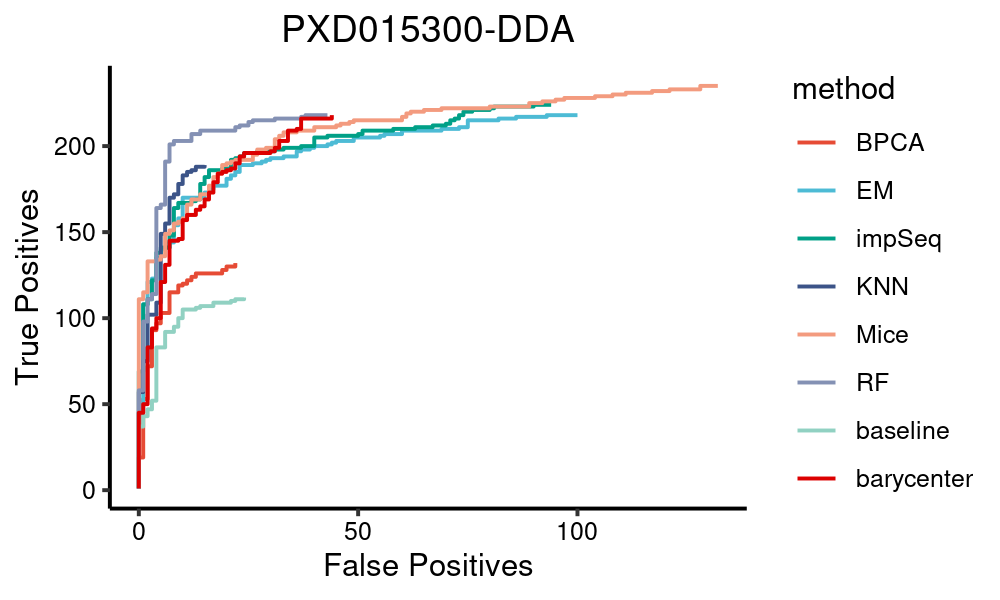

In [6]:
fig.size(3, 5)

# ROC curves

fullTables2$method <- factor(fullTables2$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","baseline","barycenter"))

p1 <- ggplot(fullTables2, aes(y=TP, x=FP, color=method, group = method)) +
#   geom_line(size=1) + 
  geom_line() + 
  scale_color_npg() + theme_classic() +
  theme(plot.title = element_text(hjust = 0.5), axis.text=element_text(colour="black")) + 
  labs(title = "PXD015300-DDA") + xlab("False Positives") + ylab("True Positives")

# p1 + p2
p1

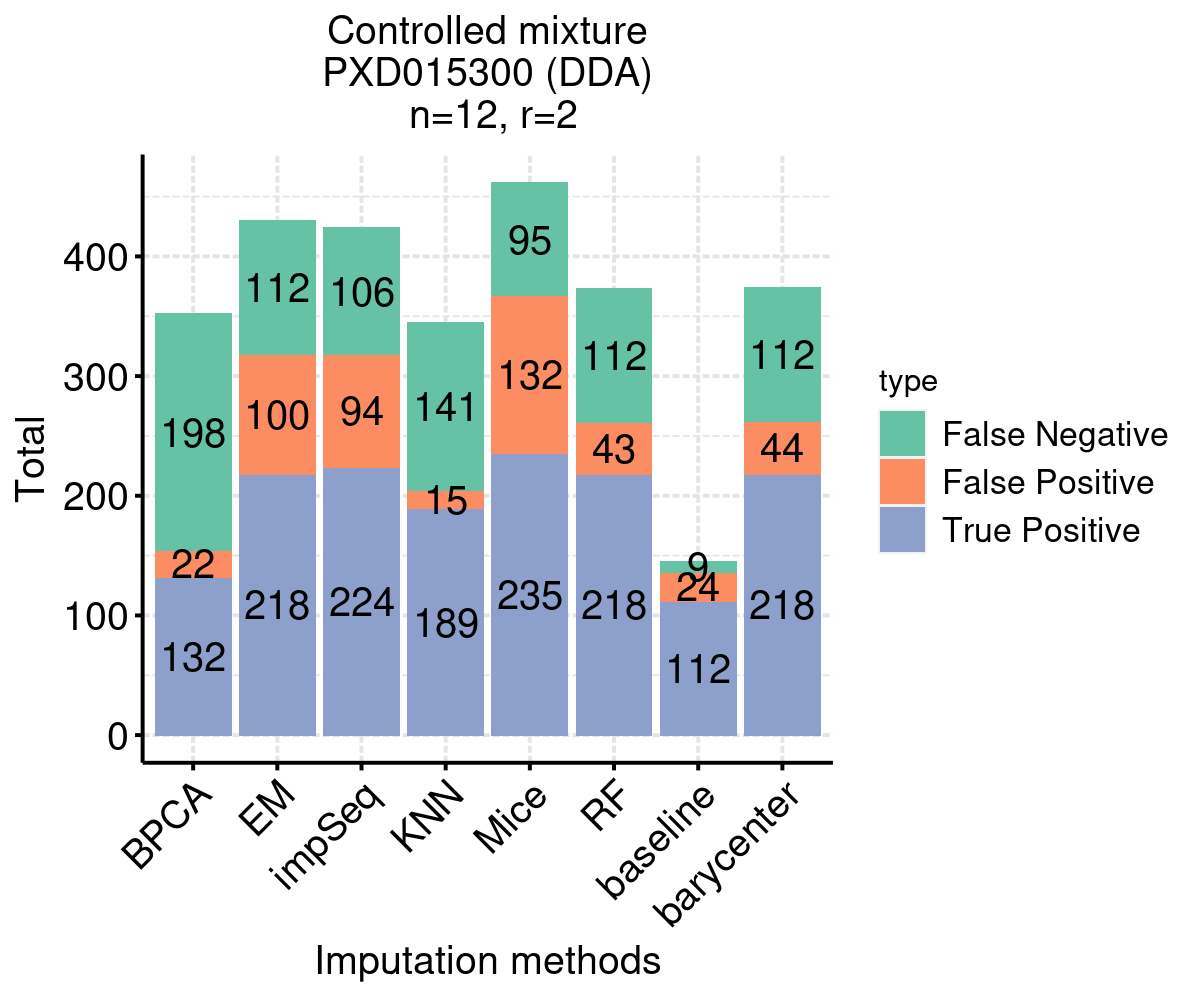

In [7]:
fig.size(5,6)

# Barplot of True positive, false positives and false negatives for all methods at FDR 0.05

ggdat <- fullTables2[,grep("method|total", colnames(fullTables2))]
ggdat <- ggdat[!duplicated(ggdat$method),]
colnames(ggdat) <- gsub("_total", "", colnames(ggdat))


ggdat <- reshape2::melt(ggdat, id = "method")
ggdat$method <- factor(ggdat$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","baseline","barycenter"))


ggdat$variable <- gsub("TP", "True Positive", ggdat$variable)
ggdat$variable <- gsub("FP", "False Positive", ggdat$variable)
ggdat$variable <- gsub("FN", "False Negative", ggdat$variable)


# png(file = "~/barplot_PXD015300.png",
#     width=6,height=5,units="in",res=1200)

p <- ggplot(ggdat, aes(x=method, y = value, fill = variable, label=value)) +
  geom_bar(stat = "identity", position="stack") +
  geom_text(size = 5, position = position_stack(vjust = 0.5)) +
  xlab('Imputation methods') + ylab('Total') + labs(fill="type", title = "Controlled mixture\nPXD015300 (DDA)\n n=12, r=2") +  
  #scale_fill_d3() +
  scale_fill_brewer(palette = "Set2") +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

# print(p)
# dev.off()

p


FALSE  TRUE 
27456  1711 

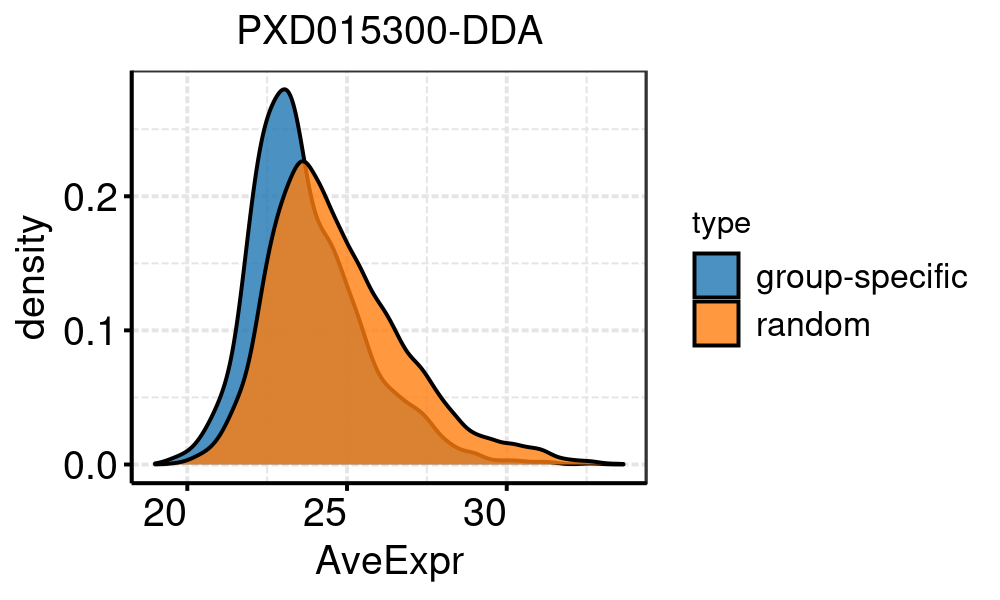

In [8]:
fig.size(3,5)

# Visualization of the ebm metric for assessment of missing types

hdp <- selectFeatures(y_dda,
                      method="ebm", group = group)

# hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1
# hist(ebms)
# plot(hdp$AveExpr, ebms, pch = 16, cex = 0.3)



library(ggExtra)

ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")

# png(file = "~/hist_missingtype_PXD015300.png",
#     width=5,height=3,units="in",res=1200)

p <- ggplot(ggdat, aes(x=AveExpr, fill = type)) +
  geom_density(alpha = 0.8) + scale_fill_d3() +
  theme_bw() + labs(title = "PXD015300-DDA")+
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 


# print(p)
# dev.off()
p

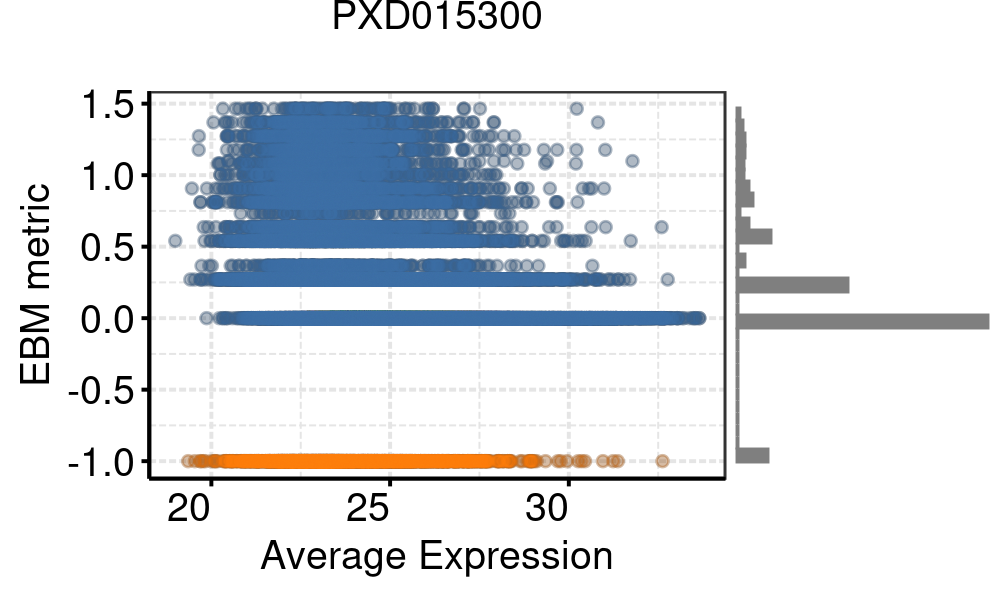

In [9]:
fig.size(3,5)

# EBM vs Ave abundance
p <- ggplot(ggdat, aes(x=AveExpr, y = metric)) +
  geom_point(alpha = 0.2) + 
  geom_point(data = subset(ggdat, metric == -1),alpha = 0.2, 
             color = "#FF7F0EFF") + 
  geom_point(data = subset(ggdat, metric != -1),alpha = 0.2, color = "#3E71A8") +
  #stat_bin_2d() +
  #geom_rug(sides = "b", alpha = 0.05) +
  theme_bw() +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) + labs(x='Average Expression', y = 'EBM metric',
               title = "PXD015300")

p1 <- ggMarginal(p, type="histogram", margins = "y", 
                 fill = "gray50", color = "gray50", 
                 size = 2.1)

p1 

### Session information

In [10]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /stornext/System/data/apps/R/R-4.1.2/lib64/R/lib/libRblas.so
LAPACK: /stornext/System/data/apps/R/R-4.1.2/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggExtra_0.9         msImpute_1.3.3      rrcovNA_0.4-15     
 [4] rrcov_1.5-5         robustbase_0.93-8   ggsci_2.9          
 [7] ggplot2_3.3.4       imputeLCMD_2.0      impute_1.66.0      
[10] pcaMethods_1.84.0